## Objective:
    
To make a theory calculation for the 2D (angular) cross correlation for the PanSTARRS Supernova and BOSS (CMASS & LOWZ) galaxy data sets, that was found previously for comparison and validation.

### Notes: 

- Need to set up like an onion

Author: Megan Tabbutt <br/>
Last Revised: 8_25_20

### Calculations:

_(2D) Cross Correlation Function (from Ross):_

$w(\theta)^{gg}_{ur} = b_u b_r \; \int \; n_u(z) n_r(z) \; \frac{dz}{d\chi} \frac{dz}{d\chi} \; d\chi \; \int \frac{k}{2 \pi} \; P(k, z(\chi)) \; J_0(\chi k \theta) \;dk $

Comoving distance formula from Dodelson:

$\chi(a) = \int^1_a \frac{da}{a^2H(a)}$ with $a = \frac{1}{1+z}$, $\chi(z) = \int^z_0 \frac{dz}{H(z)}$

and 

$H(z)^2 = H_0^2(\Omega_m(1+z)^3 + \Omega_k(1+z)^2 + \Omega_{\Lambda})$ (Wikipedia - Hubble Law)

In [1]:
# Make Jupyter Notebook full screen 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
from IPython.display import Image

In [2]:
# Working on 2015 laptop: Need to be in CCL conda environment to work on CAMB
import camb
import numpy as np
import pandas as pd
import sqlite3
import scipy as sp
import scipy.integrate
from scipy import interpolate
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
from camb import model, initialpower

In [3]:
DATA_PATH = '/Users/megantabbutt/CosmologyDataProducts/'

In [4]:
# Define Cosmology:

Omega_m = .286
Omega_k = 0
Omega_L = .65193
hubble_0 = 69.6 # km/sec/Mpc
c = 3.0*(10**5) # km/sec

bias_gal = 1.0
bias_Sne = 1.0

ombh2=0.0225
omch2=0.1431
ns=.96

In [5]:
# Define onion layer ranges:

#z_values = np.linspace() -- This gets defined below in n(z) based on the range of the actual data
#theta_list = np.logspace()
#k_list = np.linspace()

### "Ogres are like onions. Onions have layers."

-Need to get w(theta) in a layered approach and interpolate back out

$w(\theta)^{gg}_{ur} = b_u b_r \; \int \; n_u(z) n_r(z) \; \frac{dz}{d\chi} \frac{dz}{d\chi} \; d\chi \; \int \frac{k}{2 \pi} \; P(k, z(\chi)) \; J_0(\chi k \theta) \;dk $

## 1. Define terms in integrands

***

### $n(z)$

In [6]:
# Pull in the data and make into pandas dataframe 

qry_PanSTARRS_Data_All = "SELECT ID, DEC, RA, zSN, zHost FROM PanSTARRSNEW WHERE (zSN > -999) || (zHost > -999)"

connPAN = sqlite3.connect(DATA_PATH + 'PanSTARRS.db')
PanSTARRSNEW_GoodZ = pd.read_sql(qry_PanSTARRS_Data_All, con=connPAN)
connPAN.close()
PanSTARRSNEW_GoodZ.head(3) # 1129 objects over 10 pointings 

,ID,DEC,RA,zSN,zHost
0,ps0909006,1.184831,333.9500,0.284,-999.0
1,ps0909010,-4.078911,37.1182,0.270,-999.0
2,ps0910017,-5.023289,35.2775,0.320,-999.0


In [7]:
# Make a new column of "zBest" to use in the interpolation of n(z)

# Note: Take the redshift of the supernova if both are given. 
#       If redshift of supernova is unknown, take the redshift of the host. 

zBest = []
for i in PanSTARRSNEW_GoodZ.iterrows(): #.iterrows() returns a tuple (immutable object)
    if i[1]['zSN'] >= 0:
        zBest.append(i[1]['zSN'])
    else:
        zBest.append(i[1]['zHost'])
        
if PanSTARRSNEW_GoodZ.shape[0] == len(zBest):
    PanSTARRSNEW_GoodZ['zBest'] = zBest
    
PanSTARRSNEW_GoodZ.head(3)

,ID,DEC,RA,zSN,zHost,zBest
0,ps0909006,1.184831,333.9500,0.284,-999.0,0.284
1,ps0909010,-4.078911,37.1182,0.270,-999.0,0.270
2,ps0910017,-5.023289,35.2775,0.320,-999.0,0.320


In [8]:
# Make a histogram to be interpolated

bin_num = 100

Sne_z_all_hist = np.histogram(PanSTARRSNEW_GoodZ['zBest'], bins=bin_num)
#print(Sne_z_all_hist)

Sne_z_all_bin_centers = 0.5 * (Sne_z_all_hist[1][1:]+ Sne_z_all_hist[1][:-1])

Sne_z_all_hist_norm = Sne_z_all_hist[0] / sum(Sne_z_all_hist[0]) * bin_num


redshift_min = PanSTARRSNEW_GoodZ['zBest'].min()
redshift_max = PanSTARRSNEW_GoodZ['zBest'].max()

print("Min redshift = " + str(redshift_min) + "          " + "Max redshift = " + str(redshift_max))

Min redshift = 0.025          Max redshift = 0.9405700000000001


In [9]:
# interpolate:

n_sne_interpolated = interpolate.interp1d(Sne_z_all_bin_centers, Sne_z_all_hist_norm, kind='cubic', 
                                          fill_value="extrapolate")

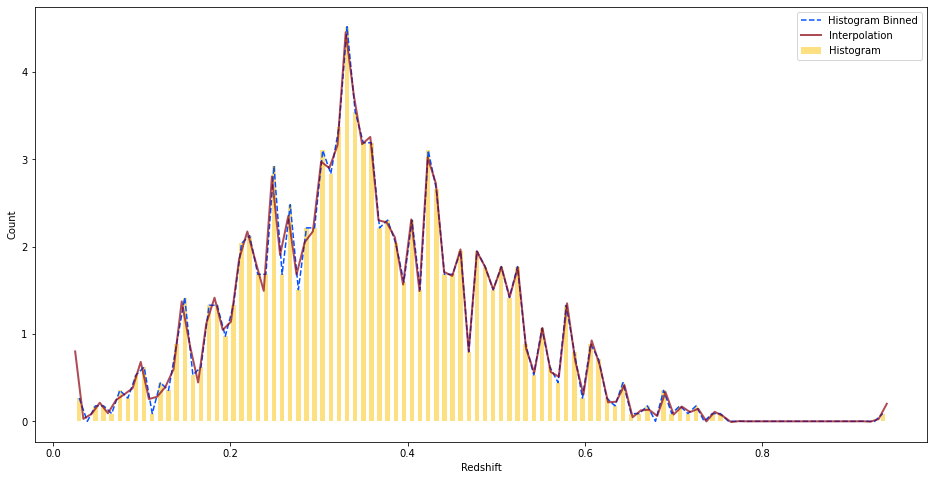

In [10]:
# Plot the histogram, input points and interpolation for comparison

z_values = np.linspace((redshift_min), (redshift_max), num=bin_num)

plt.figure(figsize=[16, 8])
plt.bar(Sne_z_all_bin_centers, Sne_z_all_hist_norm, label="Histogram", alpha=.5, color="#fac205", width=.005)
plt.plot(Sne_z_all_bin_centers, Sne_z_all_hist_norm, label="Histogram Binned", c="#0652ff", ls="--")
plt.plot(z_values, n_sne_interpolated(z_values), label="Interpolation", c="#8c000f", alpha=.7, lw=2)
plt.xlabel("Redshift")
plt.ylabel("Count")
plt.legend()
plt.show()

***

### $\chi(z)$ 

chi_z_func(z_input) - returns tuple with first element value and second element error for integral

In [11]:
# Need to get a list of zBest that is only unique entries:

zBest_unique = []
for i in zBest:
    if i not in zBest_unique:
        zBest_unique.append(i)
        
zBest_unique.sort()

In [12]:
# Define H(z) based on cosmology at start of notebook:

hubble_z_inverse_c = lambda z: c/(np.sqrt((hubble_0**2)*(Omega_m*(1 + z)**3 + Omega_k*(1 + z)**2 + Omega_L)))

In [13]:
# Define chi_z_func - returns tuple with first element value and second element error for integral

chi_z_func = lambda z: scipy.integrate.quad(hubble_z_inverse_c, 0, z)
chi_z_func(.1)

(434.70305713733796, 4.826173429088176e-12)

In [14]:
# Make a array of \chi(z) for interpolation 

chi_z_unique = []
for z in zBest_unique:
    chi_z_unique.append(chi_z_func(z)[0])

print("Redshift: " + str(zBest_unique[22]) + "      " + "Comoving Distance: " + str(chi_z_unique[22]))

Redshift: 0.101      Comoving Distance: 438.9437577227055


***

### $z(\chi)$ 

z_chi_func(chi_input) - returns redshift for a particular comoving distance

In [15]:
# Interpolate to get z(\chi)

z_chi_func = InterpolatedUnivariateSpline(chi_z_unique, zBest_unique, k=3)
z_chi_func(chi_z_unique[22])

array(0.101)

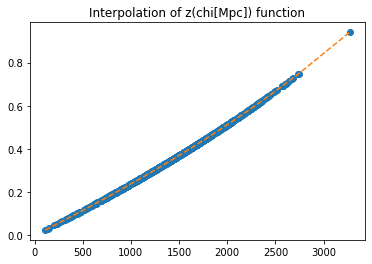

In [16]:
# Plot data and interpolation function for comparison

plt.plot(chi_z_unique, zBest_unique, 'o')
plt.plot(chi_z_unique, z_chi_func(chi_z_unique), '--')
plt.title("Interpolation of z(chi[Mpc]) function")

plt.show()

***

### $dz /\ d\chi$

z_chi_func_deriv(\chi)

In [17]:
z_chi_func_deriv = z_chi_func.derivative()
z_chi_func_deriv(chi_z_unique[22])

array(0.00023587)

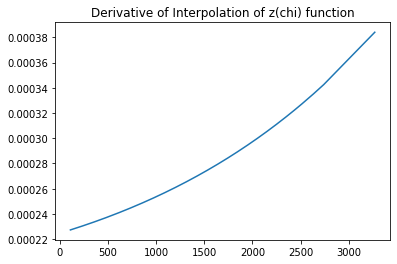

In [18]:
# Plot to check by eye
# Chi plot gives: (.6-.2)/(2500-1000) = .00026 and interpolation graph gives: (1500, .00028). Check. 

plt.plot(chi_z_unique, z_chi_func_deriv(chi_z_unique), '-')
plt.title("Derivative of Interpolation of z(chi) function")

plt.show()

***

### $P(k, z(\chi))$

matter_power_spectrum(k, z)

In [19]:
# Need the redshift and kh to have the same number of points 
# so that 2d interpolate gets arrays of the same length later. 

#Now get matter power spectra at redshift 0 and 1.0
params = camb.CAMBparams()
params.set_cosmology(H0=hubble_0, ombh2=ombh2, omch2=omch2)
params.InitPower.set_params(ns=ns)

#Note non-linear corrections couples to smaller scales than you want
params.set_matter_power(redshifts=np.linspace(0.0, 1.0, num = 100), kmax=2.0)

#Linear spectra
params.NonLinear = model.NonLinear_none
results = camb.get_results(params)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 100)

Note: redshifts have been re-sorted (earliest first)


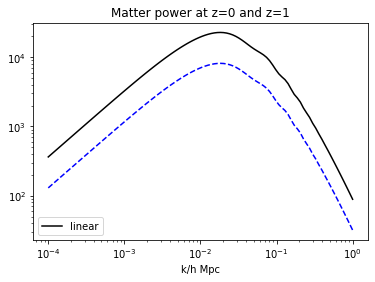

In [20]:
# plor the power spectrum for z=0 and z=1

plt.loglog(kh, pk[0,:], color='k', ls = "-")
plt.loglog(kh, pk[-1,:], color='b', ls = "--")
plt.xlabel('k/h Mpc');
plt.legend(['linear'], loc='lower left');
plt.title('Matter power at z=0 and z=1')
plt.show()

In [21]:
#Interpolate the matter power spectrum into a function with arguments k & z

matter_power_spectrum = interpolate.interp2d(kh, z, pk, kind='quintic')

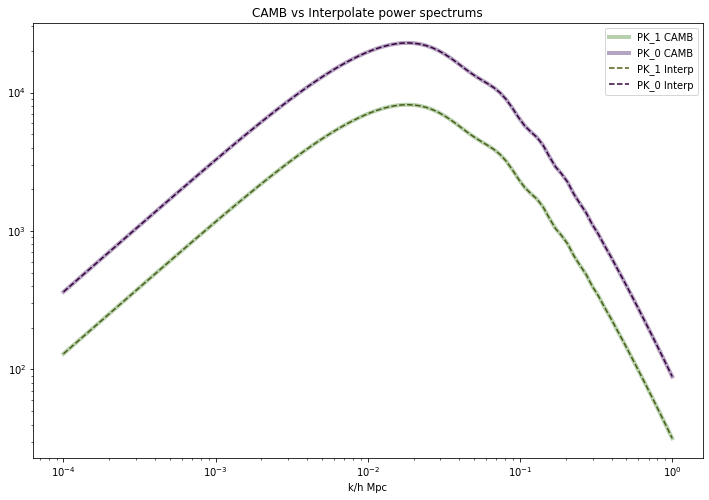

In [22]:
# Plot the matter power spectrum from CAMB and the interpolation
plt.figure(figsize=(12, 8))
kh_list = np.logspace(-4.0, 0, num=100)
z_list = np.linspace(min(z), max(z), num=100)


plt.loglog(kh, pk[-1,:], color='#88b378', ls = "-", label="PK_1 CAMB", linewidth=4, alpha=.6)
plt.loglog(kh, pk[0,:], color='#856798', ls = "-", label="PK_0 CAMB", linewidth=4, alpha=.6)

plt.loglog(kh_list, matter_power_spectrum(kh_list, z_list)[-1,:], color='#4b5d16', ls = "--", label="PK_1 Interp")
plt.loglog(kh_list, matter_power_spectrum(kh_list, z_list)[0,:], color='#36013f', ls = "--", label="PK_0 Interp")

plt.xlabel('k/h Mpc')
#plt.xlim(11**-4, 2)
plt.legend(loc = "upper right")
plt.title("CAMB vs Interpolate power spectrums")
plt.show()

***

$w(\theta)^{gg}_{ur} = b_u b_r \; \int \; n_u(z) n_r(z) \; \frac{dz}{d\chi} \frac{dz}{d\chi} \; d\chi \; \int \frac{k}{2 \pi} \; P(k, z(\chi)) \; J_0(\chi k \theta) \;dk $

/Users/megantabbutt/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:27: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


0.1
0.2
0.3
0.4
0.5
0.6
0.7


/Users/megantabbutt/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


0.8
0.9
1.0


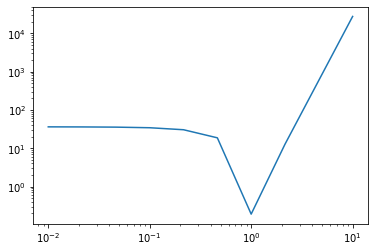

In [33]:
theta_values = np.logspace(-2, 1, 10)
chi_min = chi_z_func(redshift_min)[0]
chi_max = chi_z_func(redshift_max)[0]
chi_values = np.linspace(chi_min, chi_max, 10)
k_min = .000001
k_max = 100

corr_func_values = []
for theta in theta_values:
    
    
    integral_k_chi_values = []
    for chi in chi_values:
        
        bessel_0 = lambda k: scipy.special.jv(0, k*theta*z_chi_func(chi)) 
        integrad_k = lambda k: (k/(2*np.pi))*matter_power_spectrum(k, z_chi_func(chi))[0]*bessel_0(k)
        
        integral_k_chi = scipy.integrate.quad(integrad_k, k_min, k_max)[0]
        integral_k_chi_values.append(integral_k_chi)

    power_integral_chi_func = interpolate.interp1d(integral_k_chi_values, chi_values, kind='cubic', fill_value="extrapolate")
    #print(power_integral_chi_func(theta))
    

    
    integrand_chi = lambda x: (n_sne_interpolated(z_chi_func(x))**2) * (z_chi_func_deriv(x)**2) * power_integral_chi_func(theta) * (bias_Sne**2)
    integral_chi = scipy.integrate.quad(integrand_chi, chi_min, chi_max)[0]
    
    #print(integral_chi)
    corr_func_values.append(integral_chi)
    
    print(len(corr_func_values)/len(theta_values))
    
    
    
    
        
Correlation = power_integral_chi_func = interpolate.interp1d(corr_func_values, theta_values, kind='cubic', fill_value="extrapolate")

plt.plot(theta_values, Correlation(theta_values))
plt.yscale("log")
plt.xscale("log")

### POSSIBLE PROBLEM k vs kh? 
#kh_values = np.logspace(-4.0, 0, num=100)

#z_values
